In [1]:
import pandas as pd
from models import base_res_net
import tensorflow as tf
from tensorflow import keras
import tensorflow.compat.v1 as tfc

from src import InputPipeline

%load_ext autoreload
%autoreload 2

## Check GPU for tf

In [41]:
# Some GPU setup
# for documentation about using gpus referto: https://www.tensorflow.org/install/pip#windows-wsl2

tf.keras.backend.clear_session()

device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
try:  # prevent a previous session from being alive
  sess.close() 
except:
  pass

tfc.enable_eager_execution()
gpu_options= tfc.GPUOptions(per_process_gpu_memory_fraction = 0.8)
sess = tfc.InteractiveSession(config=tfc.ConfigProto(gpu_options=gpu_options))

In [42]:
train_df = pd.read_csv("data/train_images.csv")
class_weights = train_df["label"].value_counts()

In [43]:
class_weights = class_weights / sum(class_weights)
class_weights = {k-1: v for k,v in class_weights.to_dict().items()}

## Configure Model

In [44]:
INPUT_SHAPE = (218,218,3)

CONF = {
  "learning_rate": 0.00001,
  "batch_size": 16,
  "epochs": 50,
  "input_width": INPUT_SHAPE[0],
  "input_height": INPUT_SHAPE[1],
  "loss_function": "sparse_categorical_crossentropy",
}

In [45]:
base_model = base_res_net(INPUT_SHAPE, len(train_df["label"].unique()))
base_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 218, 218, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 218, 218, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 16  448         ['sequential[0][0]']             
                                )                                                                 
                                                                                              

## Make Input Pipeline

In [46]:
input_pipeline = InputPipeline(splits=(0.8,0.0,0.2), channels=3, batch_size=CONF["batch_size"], size=INPUT_SHAPE[:2])
input_pipeline.make_train_datasets(directory="data/train_images/train_images")

Found 3926 files belonging to 200 classes.
Using 3141 files for training.
Using 785 files for validation.
Datasets populated!


## Modeling

In [47]:
cached_train, cached_val = input_pipeline.get_cached_train_datasets()

In [48]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)
base_model.compile(loss=CONF["loss_function"],
             optimizer=keras.optimizers.Adam(CONF["learning_rate"]),
             metrics=['categorical_accuracy'],
            )

In [49]:
base_model.fit(cached_train, epochs=CONF["epochs"], validation_data=cached_val,callbacks=[callback], class_weight=class_weights)

Epoch 1/50
197/197 [==============================] - 42s 169ms/step - loss: 0.6044 - categorical_accuracy: 0.0051 - val_loss: 5.8743 - val_categorical_accuracy: 0.0025
Epoch 2/50
197/197 [==============================] - 26s 132ms/step - loss: 0.5789 - categorical_accuracy: 0.0153 - val_loss: 5.9893 - val_categorical_accuracy: 0.0127
Epoch 3/50
197/197 [==============================] - 29s 146ms/step - loss: 0.5565 - categorical_accuracy: 0.0213 - val_loss: 6.3043 - val_categorical_accuracy: 0.0153
Epoch 4/50
197/197 [==============================] - 26s 131ms/step - loss: 0.5349 - categorical_accuracy: 0.0169 - val_loss: 6.3847 - val_categorical_accuracy: 0.0127
Epoch 5/50
197/197 [==============================] - 27s 135ms/step - loss: 0.5144 - categorical_accuracy: 0.0248 - val_loss: 6.3543 - val_categorical_accuracy: 0.0153
Epoch 6/50
197/197 [==============================] - 34s 173ms/step - loss: 0.4950 - categorical_accuracy: 0.0328 - val_loss: 6.3231 - val_categorical_acc

In [50]:
input_pipeline.make_test_dataset("data/test_images")
test_ds = input_pipeline.get_cached_test_datasets()

Found 4000 files belonging to 1 classes.


In [51]:
pred = base_model.predict(test_ds)

250/250 [==============================] - 15s 57ms/step


In [52]:
pred_df=pd.DataFrame(pred)
test_df = pd.read_csv("data/test_images_sample.csv", index_col="id")
pred_frequencies = pred_df.idxmax(axis=1)
test_df["label"] = list(pred_frequencies)

<Axes: ylabel='Frequency'>

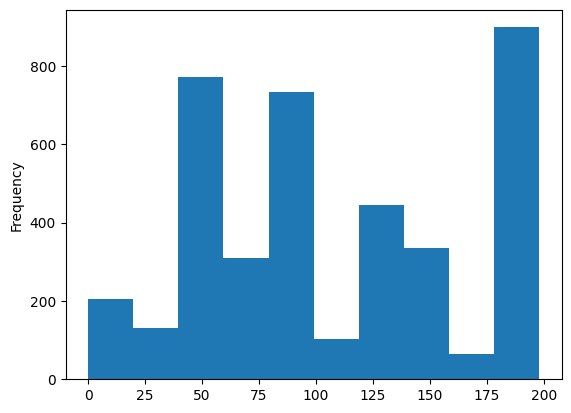

In [54]:
pred_frequencies.plot.hist()

In [55]:
test_df.to_csv("data/test_images_sample.csv")